In [124]:
import shap
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph
import copy

In [64]:
%load_ext autoreload
%autoreload 2

In [2]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [9]:
X.shape

(9932, 19)

In [6]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:7.26934
[1000]	test-cox-nloglik:6.55588
[2000]	test-cox-nloglik:6.48688
[3000]	test-cox-nloglik:6.47231
[4000]	test-cox-nloglik:6.46993
[5000]	test-cox-nloglik:6.47147
[6000]	test-cox-nloglik:6.47407
[7000]	test-cox-nloglik:6.47613
[8000]	test-cox-nloglik:6.47911
[9000]	test-cox-nloglik:6.48227
[9999]	test-cox-nloglik:6.48552


In [7]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:8.88081
[1000]	test-cox-nloglik:8.16730
[2000]	test-cox-nloglik:8.07806
[3000]	test-cox-nloglik:8.03906
[4000]	test-cox-nloglik:8.01412
[4999]	test-cox-nloglik:7.99296


In [8]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8356854248404286

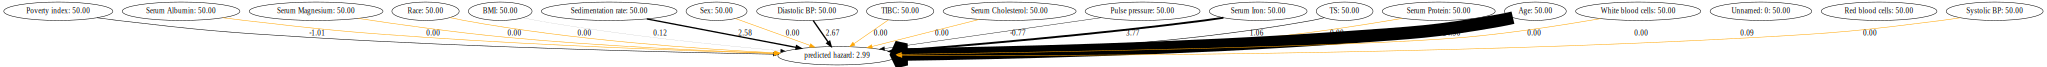

In [126]:
def build_graph(names, model, X, x):
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    nodes = [Node(name) for name in names]
    nodes.append(Node('predicted hazard', 
                      lambda *args: model.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((name, [args[i]]) for i, name in enumerate(names))), label=[0]))[0], 
                      nodes, is_target_node=True))
    graph = Graph(nodes,
                  dict((name, lambda: np.array(X)[np.random.choice(len(X))][i]) for i, name in enumerate(names)),
                  dict((name, lambda: np.array(X)[0][i]) for i, name in enumerate(names)))

    return graph

names = [name for name in xgb_train.feature_names]
graph = build_graph(names, model, X, X[29:30])
verbose = False #True
cf = CreditFlow(graph, verbose=verbose, nruns=1, visualize=verbose)
cf.run()

G = cf.credit2dot(format_str='{:.2f}')
viz_graph(G)
# save_graph(G, 'graph.png')

In [56]:
print(np.array(X)[0].shape)
print(xgb_train.feature_names)

(19,)
['Unnamed: 0', 'Age', 'Diastolic BP', 'Poverty index', 'Race', 'Red blood cells', 'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol', 'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP', 'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']


In [18]:
model.predict(xgb_train).shape

(7945,)

In [33]:
X_train[:10]

,Unnamed: 0,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
7198,7198,54.0,96.0,456.0,1.0,60.3,16.0,4.8,307.0,151.0,1.66,7.5,1.0,138.0,344.0,43.9,7.3,29.167065,42.0
9752,9752,68.0,76.0,153.0,1.0,48.4,12.0,4.0,147.0,65.0,1.75,6.2,2.0,124.0,397.0,16.4,8.2,22.540445,48.0
7618,7618,54.0,74.0,584.0,1.0,77.7,1.0,4.1,215.0,48.0,1.70,6.9,1.0,110.0,333.0,14.4,8.7,19.969070,36.0
6636,6636,72.0,88.0,147.0,1.0,47.1,18.0,4.5,208.0,165.0,1.73,7.1,2.0,185.0,281.0,58.7,6.2,18.925149,97.0
109,109,26.0,80.0,311.0,1.0,77.7,6.0,4.5,260.0,221.0,1.66,7.4,1.0,120.0,363.0,60.9,7.0,23.441069,40.0
9352,9352,33.0,98.0,108.0,1.0,48.4,20.0,4.1,199.0,126.0,1.64,7.0,2.0,140.0,409.0,30.8,5.3,38.012381,42.0
9296,9296,73.0,80.0,238.0,1.0,88.8,NaN,4.4,189.0,128.0,1.62,7.4,1.0,146.0,359.0,35.7,NaN,27.894246,66.0
8718,8718,65.0,110.0,236.0,1.0,60.1,13.0,3.4,226.0,89.0,2.16,7.0,2.0,210.0,376.0,23.7,6.8,23.698241,100.0
4885,4885,47.0,80.0,409.0,1.0,77.7,NaN,4.4,209.0,89.0,1.80,7.2,2.0,130.0,335.0,26.6,NaN,21.871516,50.0
5824,5824,68.0,80.0,118.0,1.0,42.9,48.0,4.7,262.0,76.0,1.70,7.8,2.0,150.0,377.0,20.2,9.1,35.979931,70.0


In [35]:
model.predict(xgboost.DMatrix(X_train[:1], label=y_train[:1]))

array([0.49213633], dtype=float32)

In [12]:
shap_values = shap.TreeExplainer(model)#.shap_values(X)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x88 in position 30: invalid start byte

In [14]:
X_display

,Unnamed: 0,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,Female,142.0,323.0,41.8,5.8,31.109434,50.0
1,1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,Female,156.0,331.0,26.9,5.3,32.362572,78.0
2,2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,Female,170.0,299.0,38.5,8.1,25.388497,84.0
3,3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,Female,172.0,349.0,26.9,6.7,26.446610,80.0
4,4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,Male,128.0,386.0,49.7,8.1,20.354684,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9927,9927,26.0,76.0,491.0,1.0,46.6,9.0,4.7,137.0,90.0,1.39,7.4,Male,104.0,316.0,28.5,10.7,21.468805,28.0
9928,9928,69.0,82.0,316.0,1.0,48.0,18.0,4.7,301.0,98.0,2.02,6.7,Female,130.0,334.0,29.3,7.1,23.090226,48.0
9929,9929,34.0,80.0,187.0,1.0,47.3,10.0,4.5,161.0,95.0,1.54,6.9,Female,110.0,381.0,24.9,5.4,25.797680,30.0
9930,9930,57.0,84.0,999.0,1.0,54.7,5.0,4.5,210.0,93.0,1.82,7.0,Male,130.0,337.0,27.6,6.2,23.406200,46.0
